In [145]:
# Trying to load gratings and see how the model will respond to them. 
# not very helpful

act_orients = np.arange(0,180,5)
n_images = len(act_orients)
image_batch = np.zeros((n_images, 1, 224, 224))

for ii, orient in enumerate(act_orients):
    imfn = '/user_data/mmhender/grating_ims/Grating_ex0_phase0_%ddeg.png'%orient
    from PIL import Image

    im = Image.open(imfn)
    image_batch[ii,0,:,:] = np.squeeze(np.array(im)[:,:,0])

In [146]:
image_batch.shape

(36, 1, 224, 224)

In [85]:
image_data = np.array(im)
image_data = image_data[np.newaxis, np.newaxis, :,:,0]
image_data.shape

(1, 1, 224, 224)

In [96]:
from model_fitting import initialize_fitting
from feature_extraction import texture_statistics_gabor
from utils import prf_utils

In [148]:
# Set up the Gabor filtering modules
n_ori = 12
n_sf = 8
padding_mode = 'circular'
device = 'cpu:0'
nonlin_fn = False
batch_size=100;
autocorr_output_pix=5 
n_prf_sd_out=2

# Params for the spatial aspect of the model (possible pRFs)
aperture = 1.0
aperture_rf_range = 1.1
which_prf_grid = 4
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range, which_grid = which_prf_grid)   

do_varpart=False # this doesn't do anything here
group_all_hl_feats = False # this doesn't do anything here
compute_features = True
feature_types_exclude = ['pixel', 'simple_feature_means', 'autocorrs', 'crosscorrs']

_gabor_ext_complex, _gabor_ext_simple, _fmaps_fn_complex, _fmaps_fn_simple = \
        initialize_fitting.get_gabor_feature_map_fn(n_ori, n_sf, padding_mode=padding_mode, device=device, \
                                                             nonlin_fn=nonlin_fn);    
# Initialize the "texture" model which builds on first level feature maps

_feature_extractor = texture_statistics_gabor.texture_feature_extractor(_fmaps_fn_complex, _fmaps_fn_simple, \
                                        sample_batch_size=batch_size, autocorr_output_pix=autocorr_output_pix, \
                                        n_prf_sd_out=n_prf_sd_out, aperture=aperture, \
                                        feature_types_exclude=feature_types_exclude, do_varpart=do_varpart, \
                                        group_all_hl_feats=group_all_hl_feats, device=device)      
n_pix = image_data.shape[2]
_feature_extractor.init_for_fitting((n_pix, n_pix), models, device)
n_features = _feature_extractor.n_features_total
print('number of features total: %d'%n_features)

number of pRFs: 1684
most extreme RF positions:
[0.   0.   0.04]
[ 1.2934314  -0.53575677  1.        ]
Feature types to exclude from the model:
['pixel', 'simple_feature_means', 'autocorrs', 'crosscorrs', 'complex_within_scale_crosscorrs', 'simple_within_scale_crosscorrs', 'complex_across_scale_crosscorrs', 'simple_across_scale_crosscorrs', 'complex_feature_autocorrs', 'simple_feature_autocorrs', 'pixel_stats']
number of features total: 96


In [100]:
mm=488
print(models[488,:])
center = [models[mm,0], models[mm,1]]
sd = models[mm,2]
patch_size = n_pix
prf = prf_utils.gauss_2d(center, sd, patch_size)

plt.figure();
plt.pcolormesh(prf);
plt.axis('square');
plt.axis('off');

In [150]:
features, _ = _feature_extractor(image_batch/255, models[mm],mm)
features = features.detach().cpu().numpy()

Computing complex cell features...
time elapsed = 3.26808
SKIPPING HIGHER-ORDER CORRELATIONS...
time elapsed = 0.00029
Final size of features concatenated is [36 x 96]
Feature types included are:
['complex_feature_means']


In [151]:
features.shape

(36, 96)

In [168]:
channels_to_use = np.arange(n_ori*3,n_ori*6)
channels_to_use

array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71])

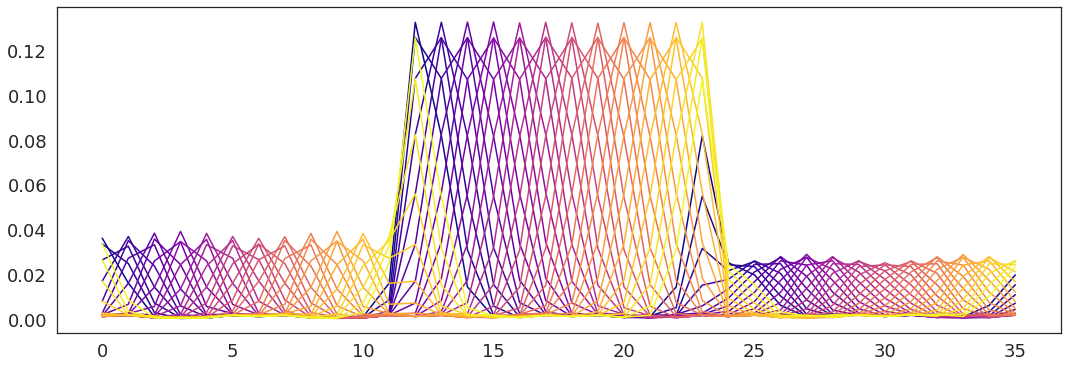

In [169]:
plt.figure(figsize=(18,6));
colors = cm.plasma(np.linspace(0,1,n_images))
for ii in range(n_images):
    plt.plot(features[ii,channels_to_use],color=colors[ii,:])

In [152]:
val_cc = out['val_cc'][:,0]
orients_deg
vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance
wts = out['best_params'][1][vidx,:,0]
wts.shape

(96,)

In [170]:
resp = features[:,channels_to_use] @ wts[channels_to_use]
resp

array([0.00653255, 0.00565683, 0.00421731, 0.00294491, 0.00265601,
       0.00352382, 0.00508923, 0.00634842, 0.00682211, 0.00691659,
       0.00680249, 0.00683298, 0.00692083, 0.00686036, 0.00661247,
       0.00645534, 0.00666078, 0.00715624, 0.00767854, 0.00807552,
       0.00817822, 0.00806591, 0.00785957, 0.00749965, 0.00694118,
       0.00636488, 0.00611505, 0.00653547, 0.00749587, 0.00834967,
       0.00816638, 0.00705511, 0.00599444, 0.00567818, 0.00611459,
       0.00660765], dtype=float32)

In [196]:
act_orients = np.arange(0,180,15)
inds = (act_orients/15).astype('int')
n_images = len(act_orients)
features = np.zeros((n_images,96))
for ii in range(n_images):
    features[ii,np.arange(inds[ii],96,n_ori)] = 1
    features[ii,np.arange(inds[ii]-1,96,n_ori)] = 0.8
    features[ii,np.arange(inds[ii]+1,96,n_ori)] = 0.8
resp = features @ wts

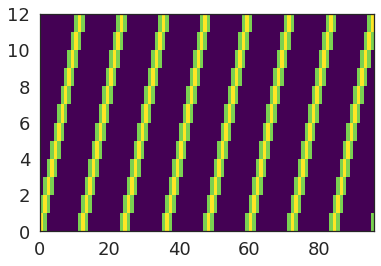

In [197]:
plt.figure();
plt.pcolormesh(features)

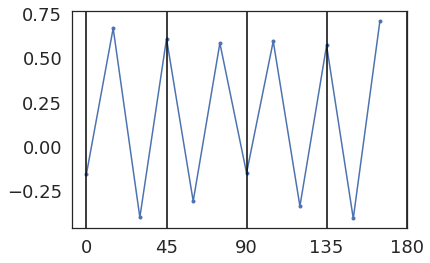

In [198]:
plt.figure();
plt.plot(act_orients, resp, '.-')
plt.xticks(np.arange(0,181,45));
for oo in np.arange(0,181,45):
    plt.axvline(oo,color='k')

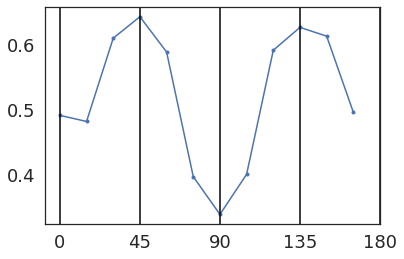

In [162]:
plt.figure();
plt.plot(orients_deg, mean_orient_corr[vidx,:], '.-')
plt.xticks(np.arange(0,181,45));
for oo in np.arange(0,181,45):
    plt.axvline(oo,color='k')

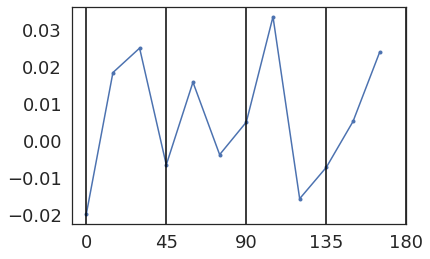

In [189]:
plt.figure();
plt.plot(orients_deg, allw_reshaped[vidx,:,0], '.-')
# plt.plot(orients_deg, mean_orient_weights[vidx,:], '.-')
plt.xticks(np.arange(0,181,45));
for oo in np.arange(0,181,45):
    plt.axvline(oo,color='k')

In [122]:
image_data

array([[[[124, 124, 124, ..., 124, 124, 124],
         [124, 124, 124, ..., 124, 124, 124],
         [124, 124, 124, ..., 124, 124, 124],
         ...,
         [124, 124, 124, ..., 124, 124, 124],
         [124, 124, 124, ..., 124, 124, 124],
         [124, 124, 124, ..., 124, 124, 124]]]], dtype=uint8)

In [112]:
image_data.shape

(1, 1, 224, 224)

In [172]:
np.arange(0,96,n_ori)

array([ 0, 12, 24, 36, 48, 60, 72, 84])

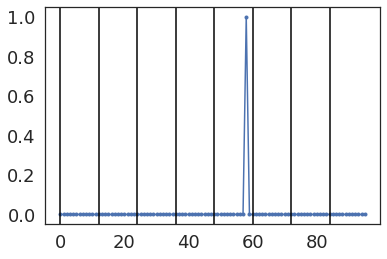

In [177]:
plt.figure();
plt.plot(features, '.-');
for sf in range(n_sf):
    plt.axvline(n_ori*sf, color='k')

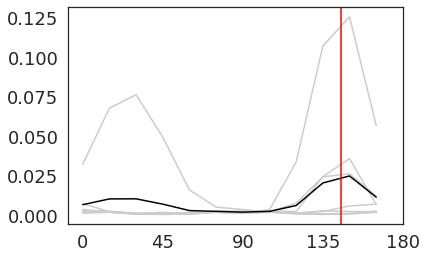

In [132]:
plt.figure();
features_reshaped = np.reshape(features, [n_ori, n_sf], order='F')
plt.plot(orients_deg, features_reshaped,color=[0.8, 0.8, 0.8]);
plt.plot(orients_deg,np.mean(features_reshaped, axis=1),color='k')
plt.xticks(np.arange(0,181,45));
plt.axvline(act_orient, color='r')
# for sf in range(n_sf):
#     plt.axvline(n_ori*sf, color='k')

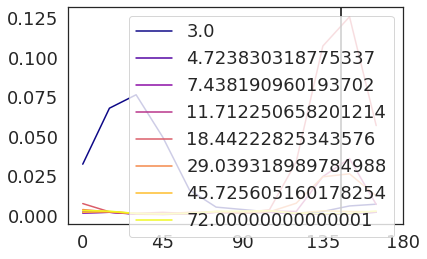

In [137]:
plt.figure();
features_reshaped = np.reshape(features, [n_ori, n_sf], order='F')
colors = cm.plasma(np.linspace(0,1,n_sf))
for sf in range(n_sf):
    plt.plot(orients_deg, features_reshaped[:,sf],color=colors[sf,:]);
# plt.plot(orients_deg,np.mean(features_reshaped, axis=1),color='k')
plt.xticks(np.arange(0,181,45));
plt.axvline(act_orient, color='k')
# for sf in range(n_sf):
#     plt.axvline(n_ori*sf, color='k')

plt.legend(cyc_per_stim)